In [ ]:
#the code pipeline for the feature extraction for respiratory methods are highly similar with few differences
#below, we show how to extract features for one participant using the thorax RIP raw data

# FEATURE EXTRACTION EXAMPLE FOR ABDOMEN RIP OF A PARTICIPANT

In [1]:
import pandas as pd
#we first read in a data set of one participant as an example
#it contains the raw Thorax RIP data (already inverted around the x axis so the increases represent inspiration)
#it also contains a column called Task_Label_2 which includes our task labels for the procedure

#data can also be read in from other formats as long as it is turned into a pandas dataframe format

#the dataframe should not be datetime indexed. if it is, drop the indexes before following with the next cells
# read the HDF5 file into a DataFrame
df_abdomen = pd.read_hdf('df_abdomen.h5', 'df_abdomen')

# Display the first few rows of the dataframe to check it
df_abdomen

RSP_Raw Task_Label_2
0      -14268.000000         10.0
1      -14270.893072         10.0
2      -14268.000000         10.0
3      -14266.814324         10.0
4      -14269.000000         10.0
...              ...          ...
959996 -14211.000000         94.0
959997 -14204.934309         94.0
959998 -14211.000000         94.0
959999 -14233.120446         94.0
960000 -14211.000000         94.0

[960001 rows x 2 columns]

In [2]:
#below, we are customizing the steps of respiration processing and defining the function via neurokit2
#the main steps include cleaning and identification of troughs and peaks
def my_cleaning(rsp_signal, sampling_rate):
    # My custom cleaning logic
    cleaned = nk.signal_filter(
        rsp_signal,
        sampling_rate=sampling_rate,
        lowcut=0.05,
        highcut=0.60,
        order=2,
        method='butterworth'
    )
    return cleaned

import pandas as pd

from neurokit2 import as_vector
from neurokit2 import signal_rate
from neurokit2 import rsp_amplitude
from neurokit2 import rsp_clean
from neurokit2 import rsp_methods
from neurokit2 import rsp_peaks
from neurokit2 import rsp_phase
from neurokit2 import rsp_plot
from neurokit2 import rsp_rvt
from neurokit2 import rsp_symmetry

def my_process_hexoskin(
    rsp_signal,
    sampling_rate=256,
    method="scipy",
    method_rvt="harrison2021",
    report=None,
    **kwargs
):
    """**Process a respiration (RSP) signal**

    Convenience function that automatically processes a respiration signal with one of the
    following methods:

    * `Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>`_

    * `BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>`_

    Parameters
    ----------
    rsp_signal : Union[list, np.array, pd.Series]
        The raw respiration channel (as measured, for instance, by a respiration belt).
    sampling_rate : int
        The sampling frequency of :func:`.rsp_signal` (in Hz, i.e., samples/second).
    method : str
        The processing pipeline to apply. Can be one of ``"khodadad2018"`` (default)
        or ``"biosppy"``.
    method_rvt : str
        The rvt method to apply. Can be one of ``"harrison2021"`` (default), ``"birn2006"``
        or ``"power2020"``.
    report : str
        The filename of a report containing description and figures of processing
        (e.g. ``"myreport.html"``). Needs to be supplied if a report file
        should be generated. Defaults to ``None``. Can also be ``"text"`` to
        just print the text in the console without saving anything.
    **kwargs
        Other arguments to be passed to specific methods. For more information,
        see :func:`.rsp_methods`.

    Returns
    -------
    signals : DataFrame
        A DataFrame of same length as :func:`.rsp_signal` containing the following columns:

        * ``"RSP_Raw"``: the raw signal.
        * ``"RSP_Clean"``: the cleaned signal.
        * ``"RSP_Peaks"``: the respiratory peaks (exhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Troughs"``: the respiratory troughs (inhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Rate"``: breathing rate interpolated between inhalation peaks.
        * ``"RSP_Amplitude"``: breathing amplitude interpolated between inhalation peaks.
        * ``"RSP_Phase"``: breathing phase, marked by "1" for inspiration and "0" for expiration.
        * ``"RSP_PhaseCompletion"``: breathing phase completion, expressed in percentage (from 0 to
          1), representing the stage of the current respiratory phase.
         * ``"RSP_RVT"``: respiratory volume per time (RVT).
    info : dict
        A dictionary containing the samples at which inhalation peaks and exhalation troughs occur,
        accessible with the keys ``"RSP_Peaks"``, and ``"RSP_Troughs"`` respectively, as well as the
        signals' sampling rate.

    See Also
    --------
    rsp_clean, rsp_findpeaks, .signal_rate, rsp_amplitude, rsp_plot, rsp_phase, rsp_rvt, rsp_symmetry

    Examples
    --------
    .. ipython:: python

      import neurokit2 as nk

      rsp = nk.rsp_simulate(duration=90, respiratory_rate=15)
      signals, info = nk.rsp_process(rsp, sampling_rate=250, report="text")

      @savefig p_rsp_process_1.png scale=100%
      fig = nk.rsp_plot(signals, sampling_rate=250)
      @suppress
      plt.close()

    """
    # sanitize input
    rsp_signal = as_vector(rsp_signal)
    methods = rsp_methods(
        sampling_rate=sampling_rate, method=method, method_rvt=method_rvt, **kwargs
    )

    # clean signal
    rsp_cleaned = my_cleaning(rsp_signal, sampling_rate=sampling_rate)

    # extract, fix and format peaks
    peak_signal, info = rsp_peaks(
        rsp_cleaned,
        sampling_rate=sampling_rate,
        method=methods["method_peaks"],
        peak_distance=1.65, 
        **methods["kwargs_peaks"]
    )
    
    info["sampling_rate"] = sampling_rate  # Add sampling rate in dict info

    # getting additional parameters
    phase = rsp_phase(peak_signal, desired_length=len(rsp_signal))
    amplitude = rsp_amplitude(rsp_cleaned, peak_signal)
    rate = signal_rate(
        info["RSP_Troughs"], sampling_rate=sampling_rate, desired_length=len(rsp_signal)
    )
    symmetry = rsp_symmetry(rsp_cleaned, peak_signal)
    rvt = rsp_rvt(
        rsp_cleaned,
        method=methods["method_rvt"],
        sampling_rate=sampling_rate,
        silent=True,
    )

    # preparing output
    signals = pd.DataFrame(
        {
            "RSP_Raw": rsp_signal,
            "RSP_Clean": rsp_cleaned,
            "RSP_Amplitude": amplitude,
            "RSP_Rate": rate,
            "RSP_RVT": rvt,
        }
    )
    signals = pd.concat([signals, phase, symmetry, peak_signal], axis=1)

    if report is not None:
       
        if ".html" in str(report):
            fig = rsp_plot(signals, sampling_rate=sampling_rate)
        else:
            fig = None
        create_report(file=report, signals=signals, info=methods, fig=fig)

    return signals, info


In [3]:
#below, we define a function which will, for each of the task names we enter, clean the segments of interest and do
#peak trough detection within the 30-sec segment entered along with the 5 seconds before and after each segment
#it creates a new dataframe per segment with RSP_Raw (stays same), RSP_Cleaned, and RSP_Peaks, RSP_Troughs
#Whenever there is a peak, RSP_Peaks = 1, and whenever there is a trough, RSP_Troughs = 1

#the function also visualizes the cleaned segments with the peak and troughs
participant_id = 71402 #this changes for each participant, needed only for the visualizations (is on the title of each graph)

def process_and_visualize(results_hexoskin, tasks):
    hexoskin_data = df_abdomen
    tasks_dataframes = {}

    # Segmenting the dataframe into task-specific dataframes
    for task in tasks:
        task_indices = hexoskin_data[hexoskin_data['Task_Label_2'] == task].index

        if not task_indices.empty:
            start_index = task_indices[0] - 1280
            end_index = task_indices[-1] + 1280
            start_index = max(start_index, 0)
            end_index = min(end_index, len(hexoskin_data) - 1)
            task_dataframe = hexoskin_data.loc[start_index:end_index, ['RSP_Raw', 'Task_Label_2']]
            tasks_dataframes[task] = task_dataframe

    # processing each task-specific dataframe
    processed_tasks_dataframes = {}
    for task, task_df in tasks_dataframes.items():
        rsp_signal = task_df['RSP_Raw']
        processed_data, _ = my_process_hexoskin(rsp_signal, sampling_rate=256)
        processed_data.reset_index(drop=True, inplace=True)
        task_df_reset = task_df.reset_index(drop=True)
        processed_data_with_label = processed_data.merge(task_df_reset[['Task_Label_2']], left_index=True, right_index=True, how='left')
        processed_tasks_dataframes[task] = processed_data_with_label

    # visualizing the actual task portions - portions of interest
    for task, df in processed_tasks_dataframes.items():
        task_specific_indices = df.index[df['Task_Label_2'] == task]
        if not task_specific_indices.empty:
            task_start = task_specific_indices[0]
            task_end = task_specific_indices[-1]

            plt.figure(figsize=(15, 4))
            plt.plot(df.loc[task_start:task_end, 'RSP_Clean'], label='RSP_Clean', color='black')
            peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
            troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

            for peak in peaks:
                plt.axvline(x=peak, color='red', linestyle='--', alpha=0.7)
            for trough in troughs:
                plt.axvline(x=trough, color='blue', linestyle='--', alpha=0.7)

            plt.title(f"Participant {participant_id}, Task: {task}")
            plt.xlabel("Samples")
            plt.ylabel("RSP_Clean")
            plt.legend()
            plt.show()
    
    return processed_tasks_dataframes


C:\Users\msa583\AppData\Local\Temp\ipykernel_13684\737448005.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13684\737448005.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


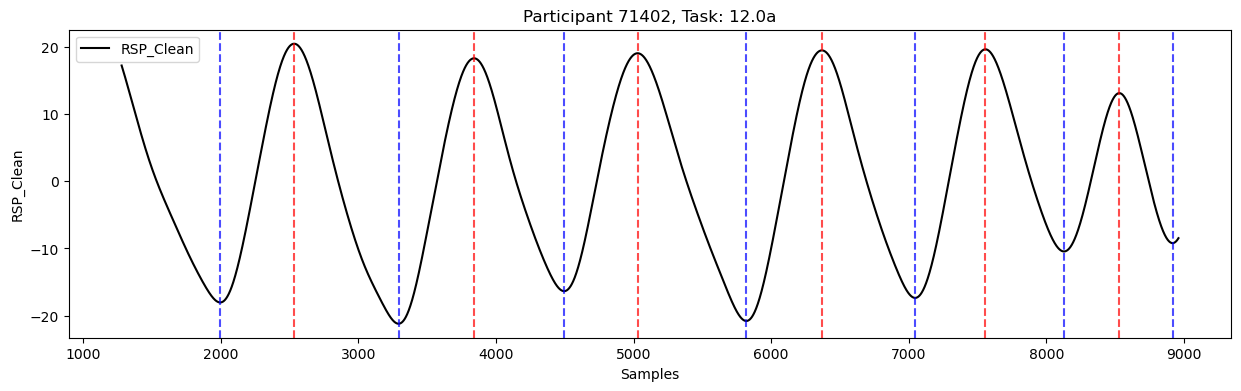

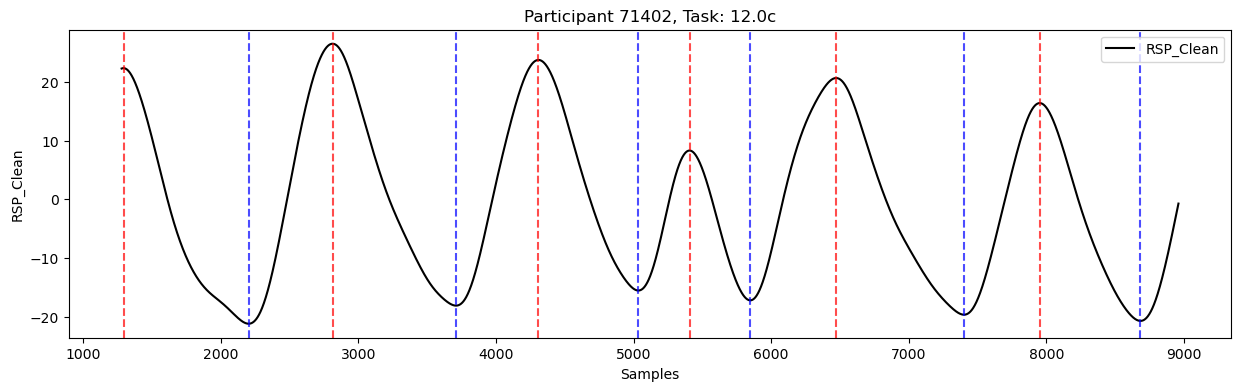

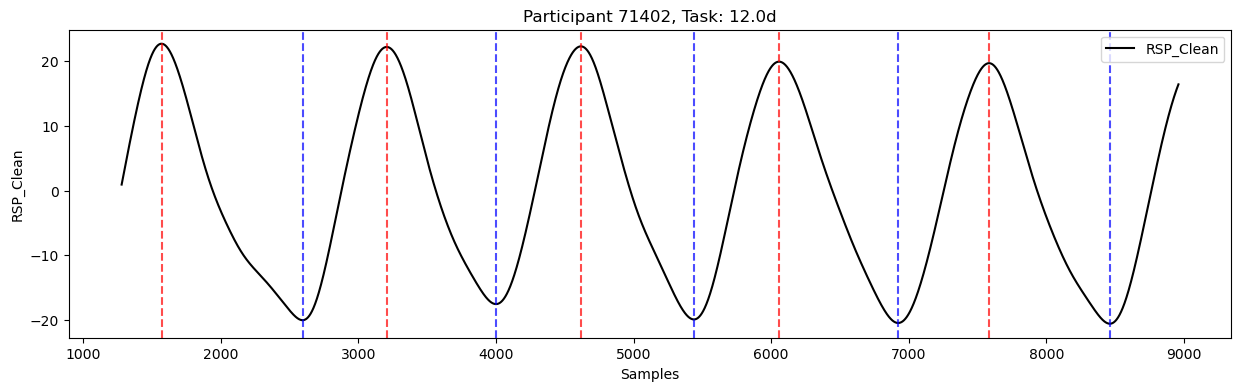

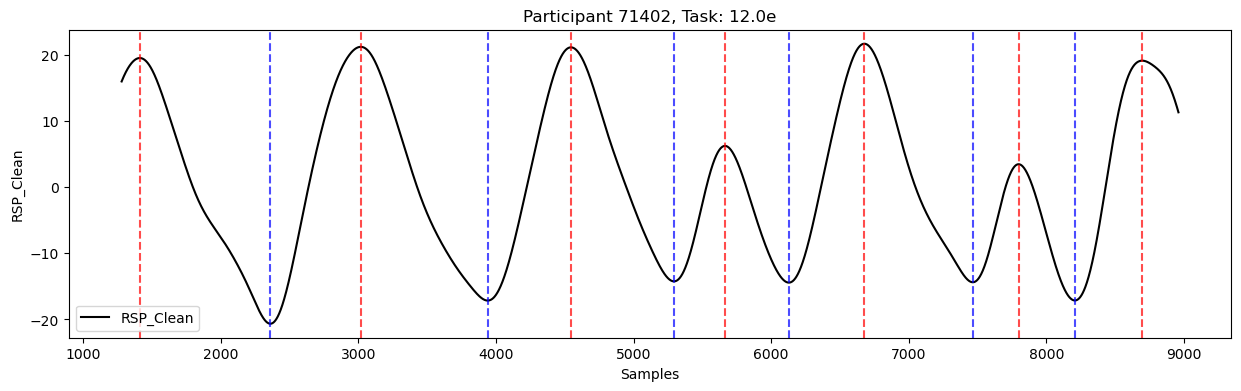

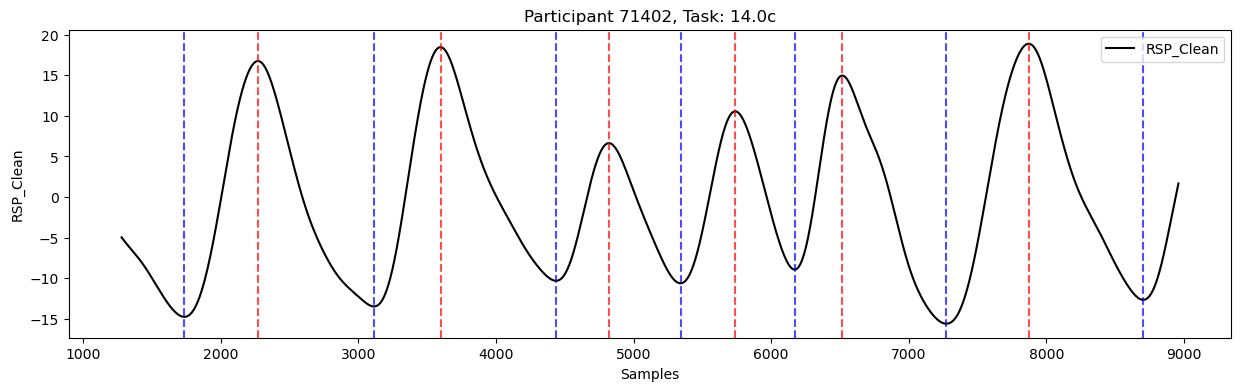

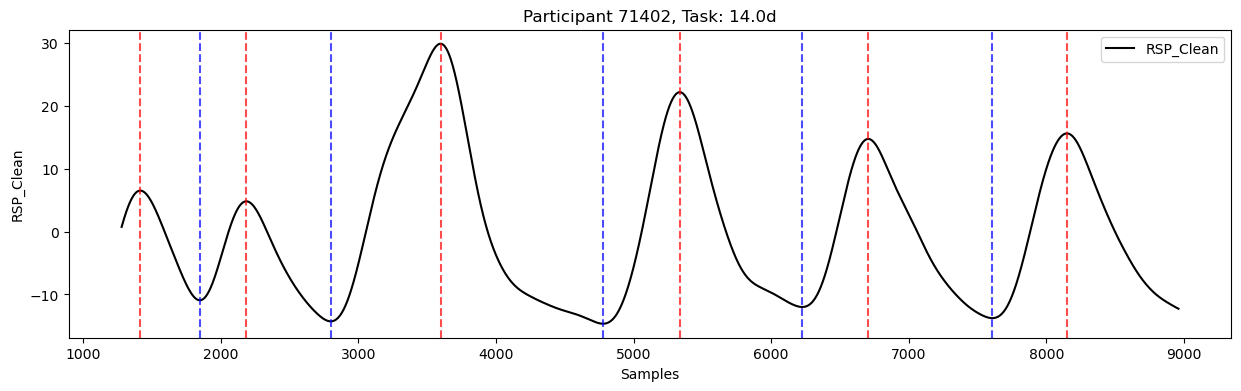

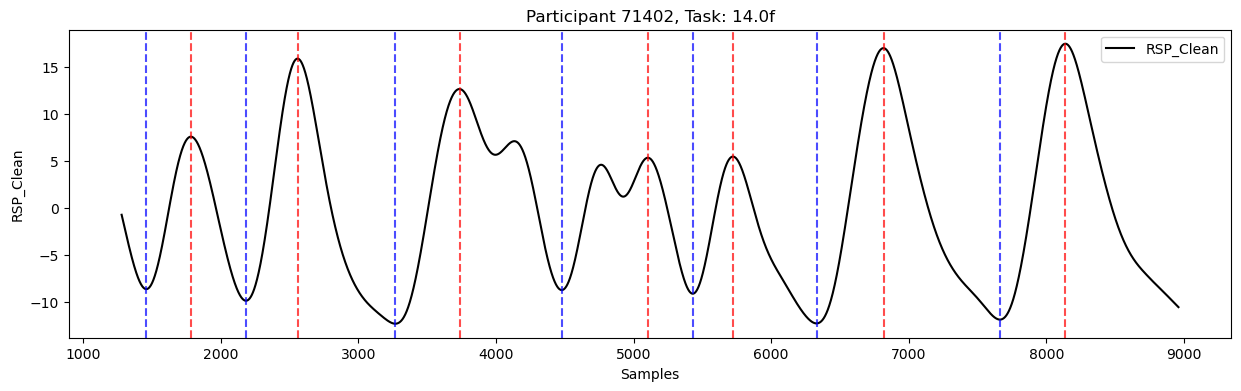

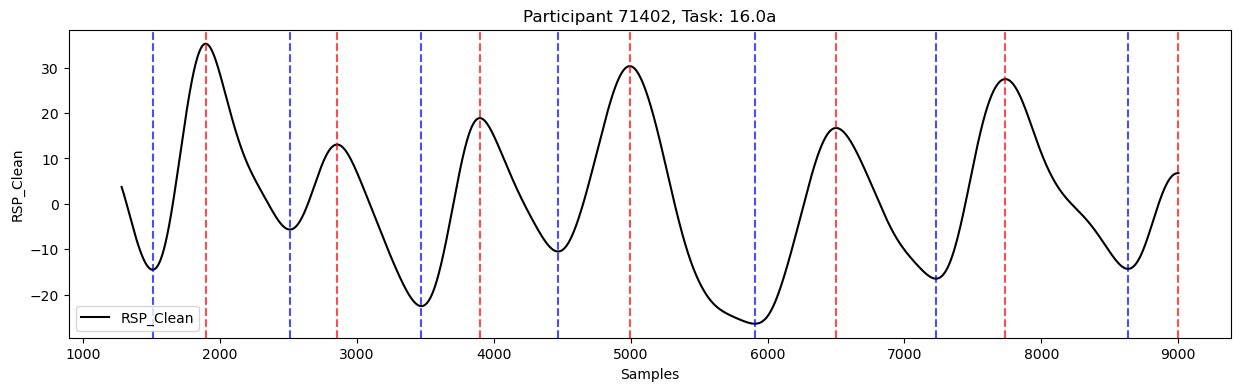

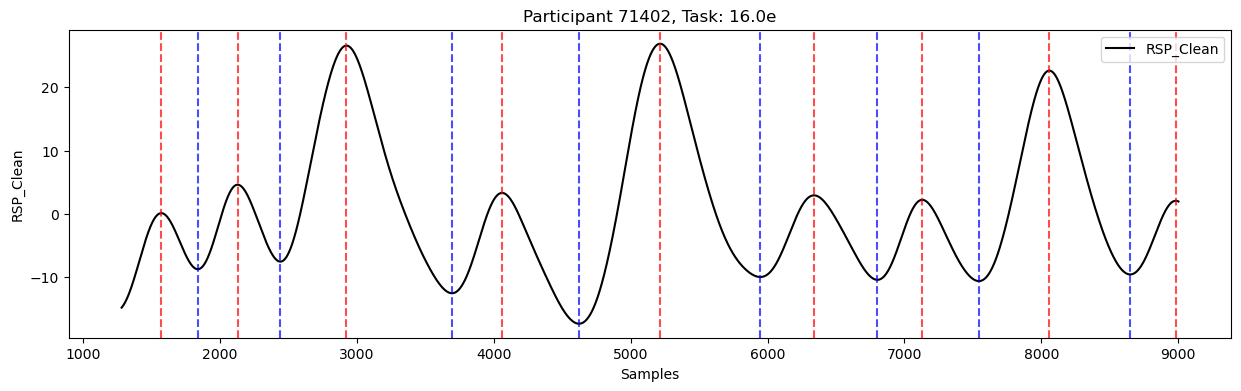

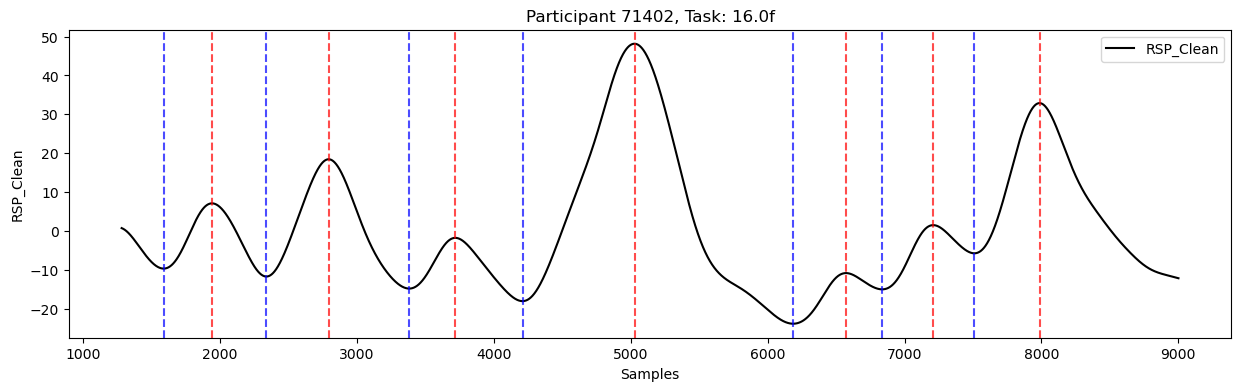

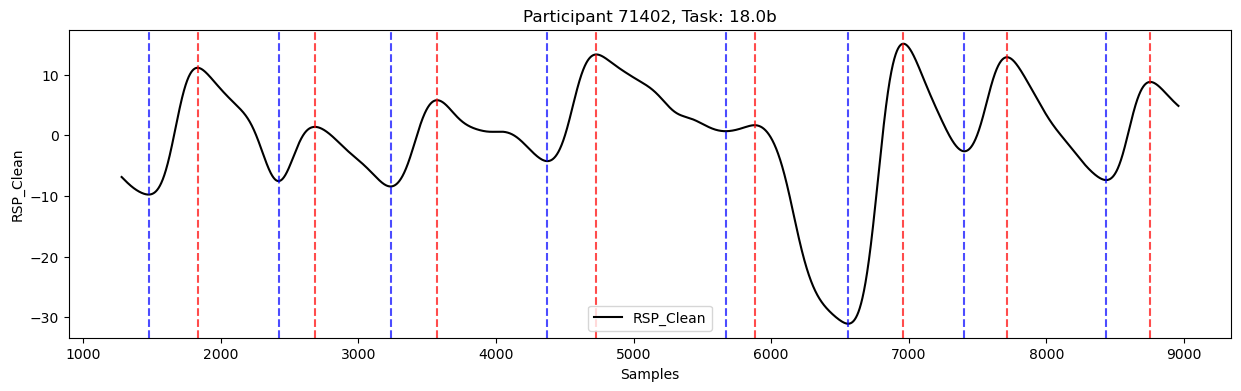

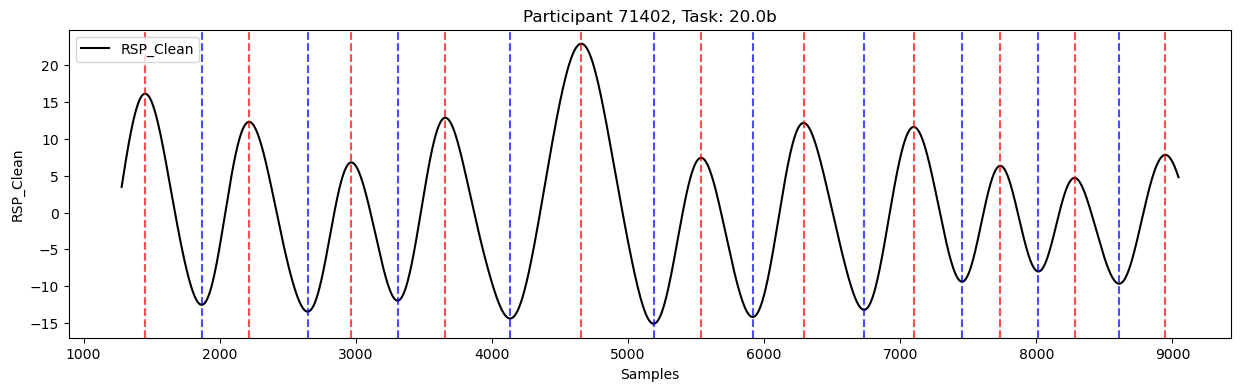

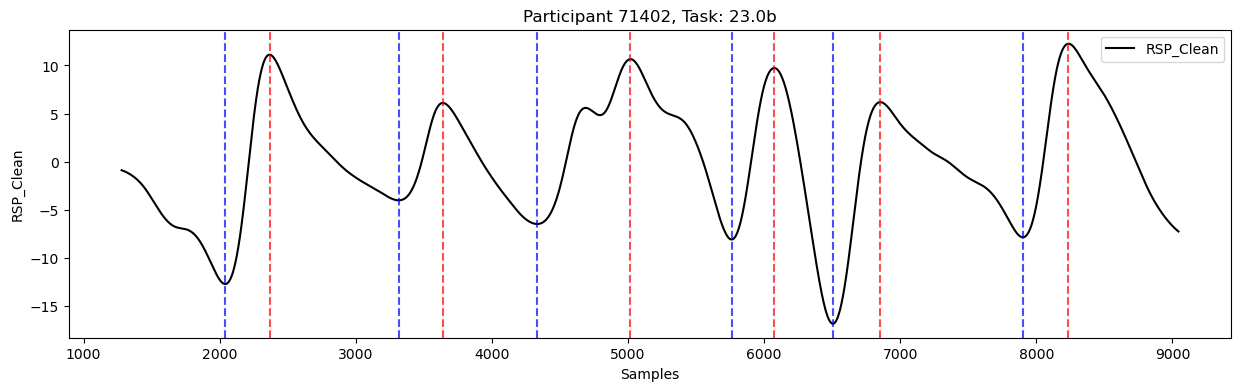

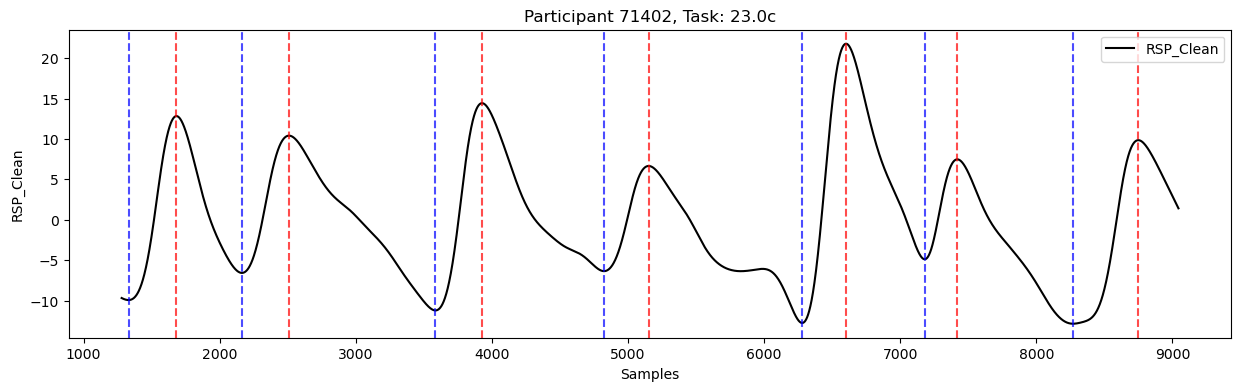

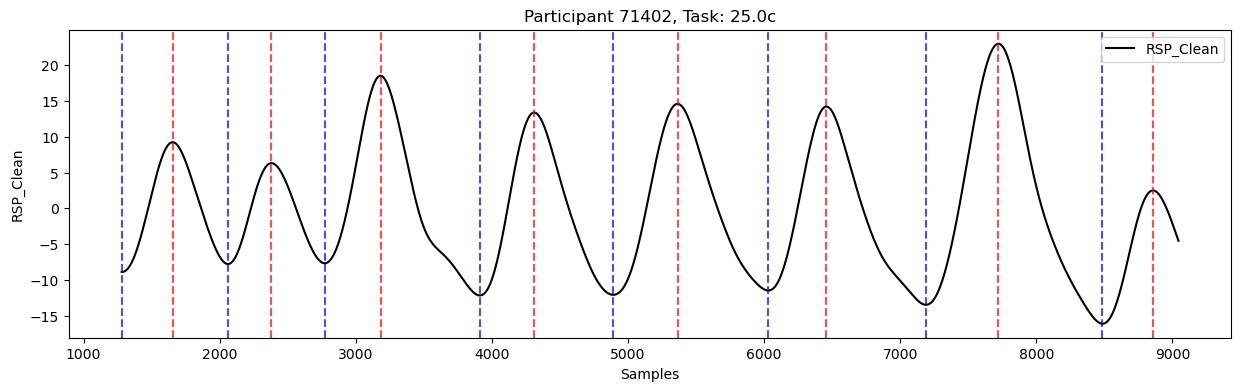

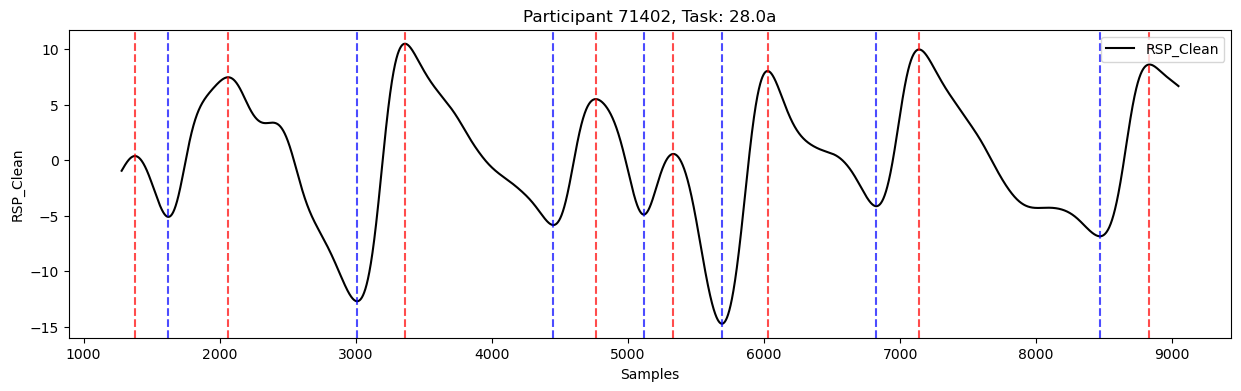

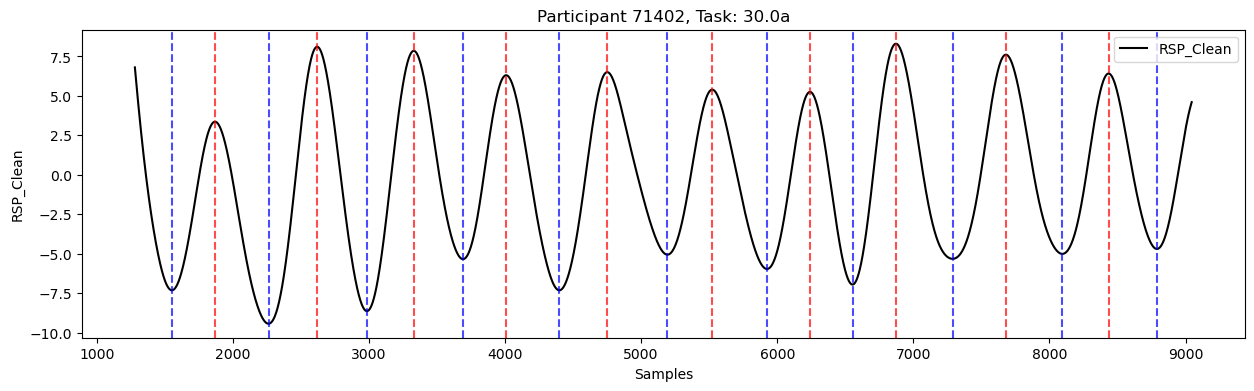

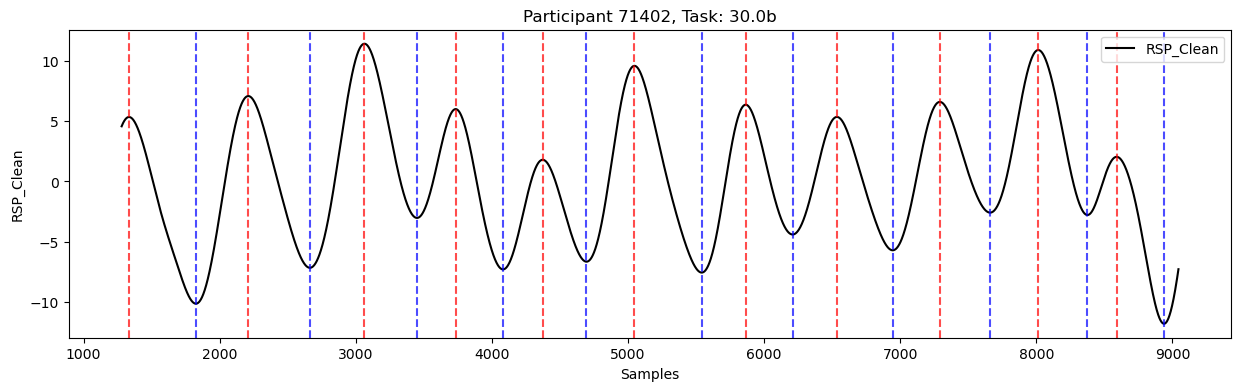

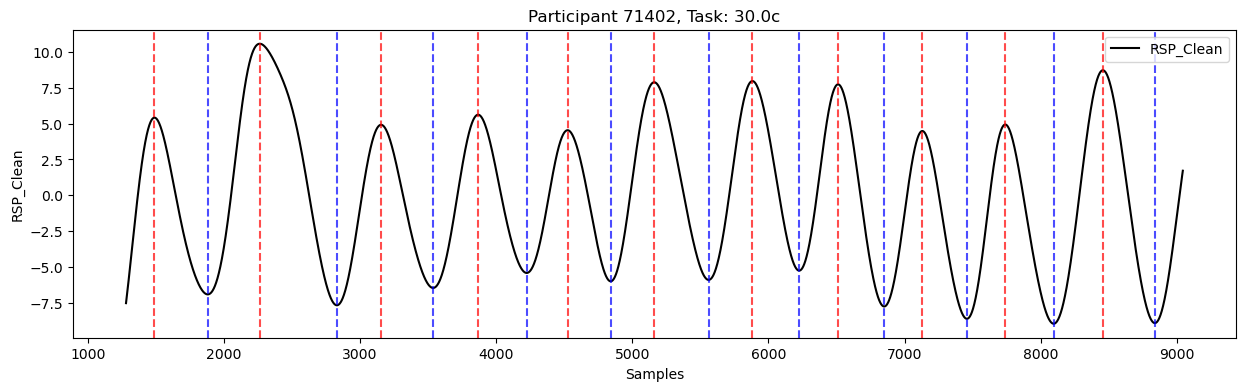

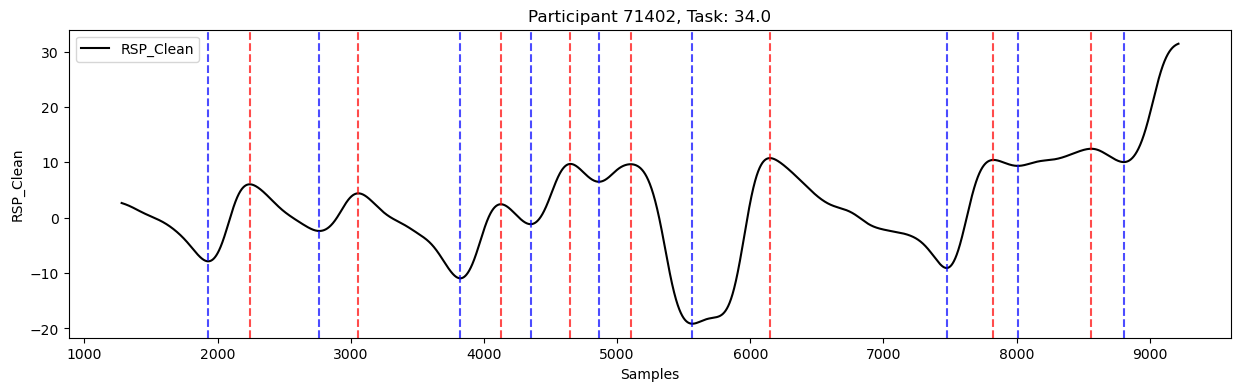

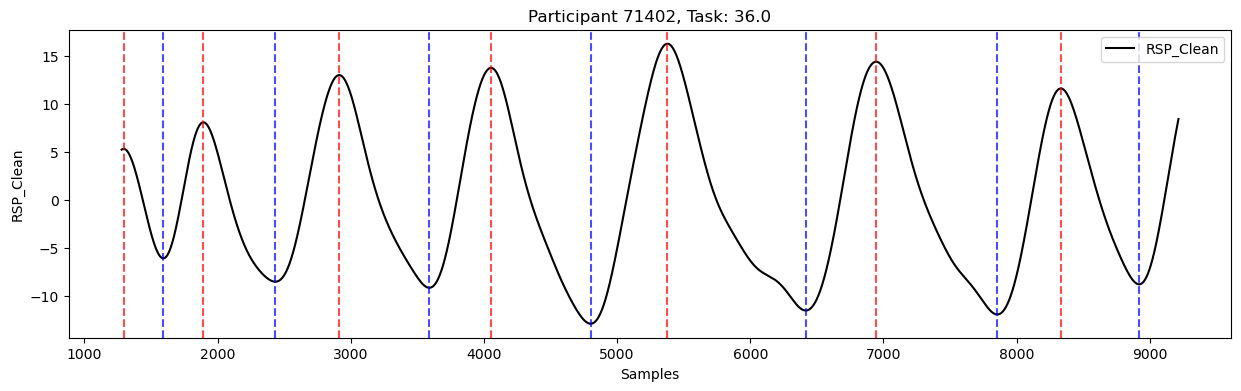

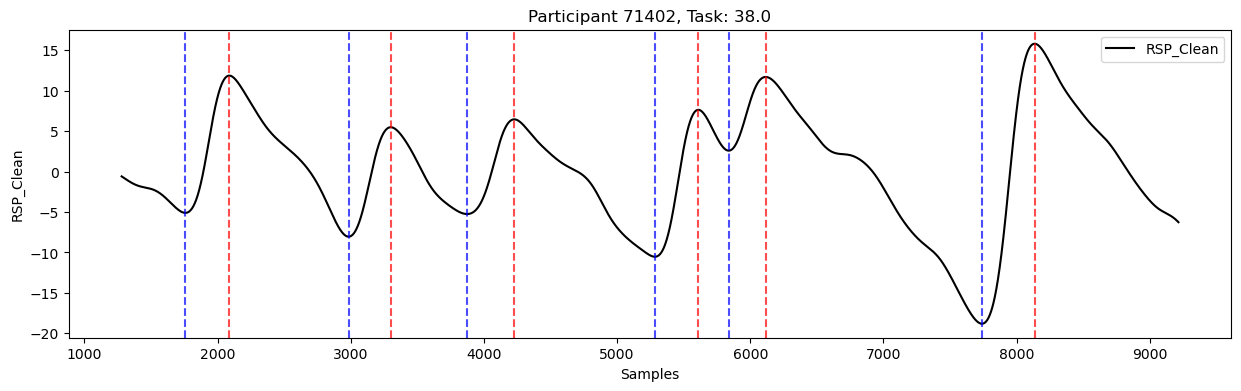

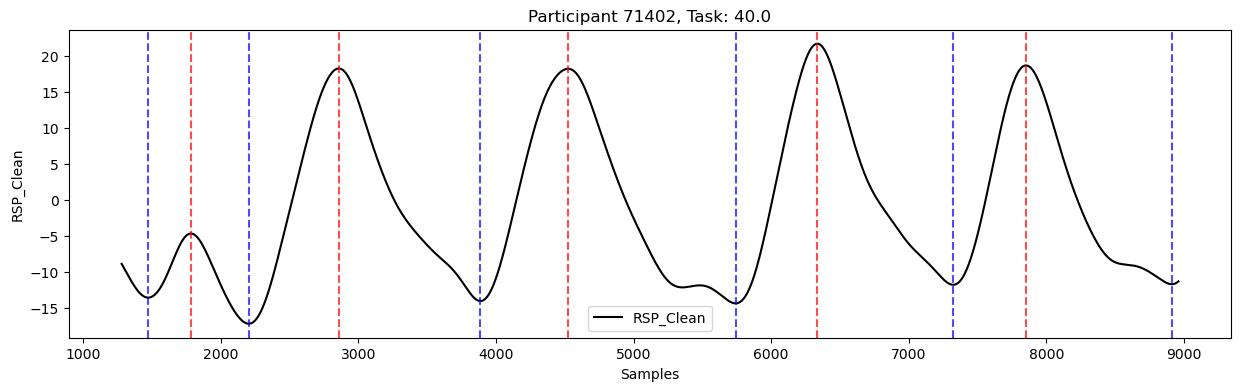

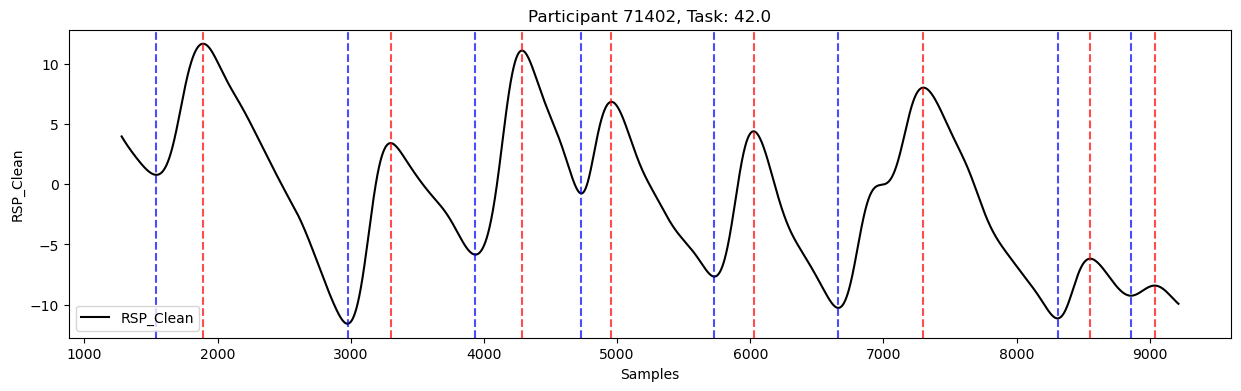

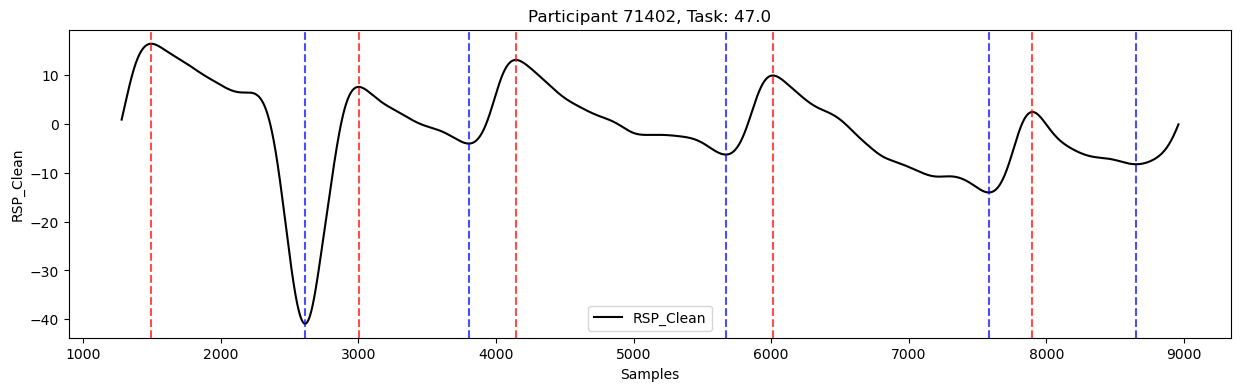

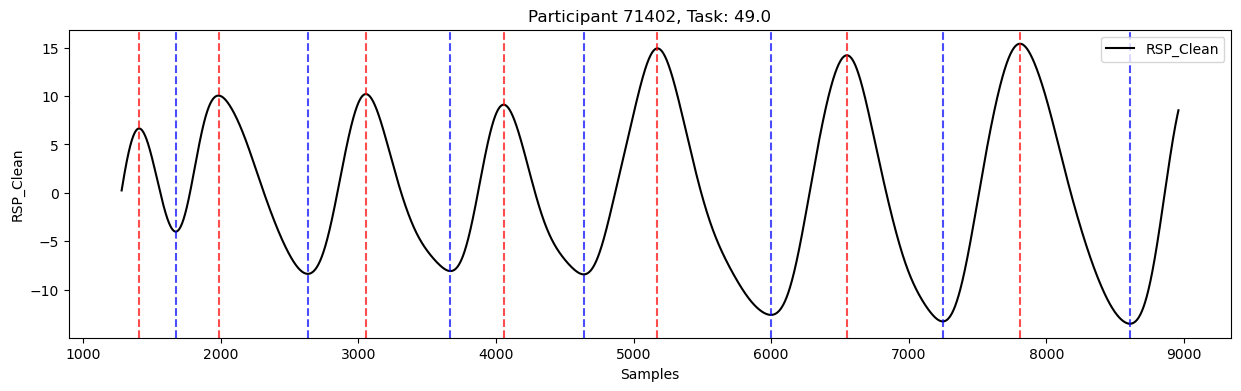

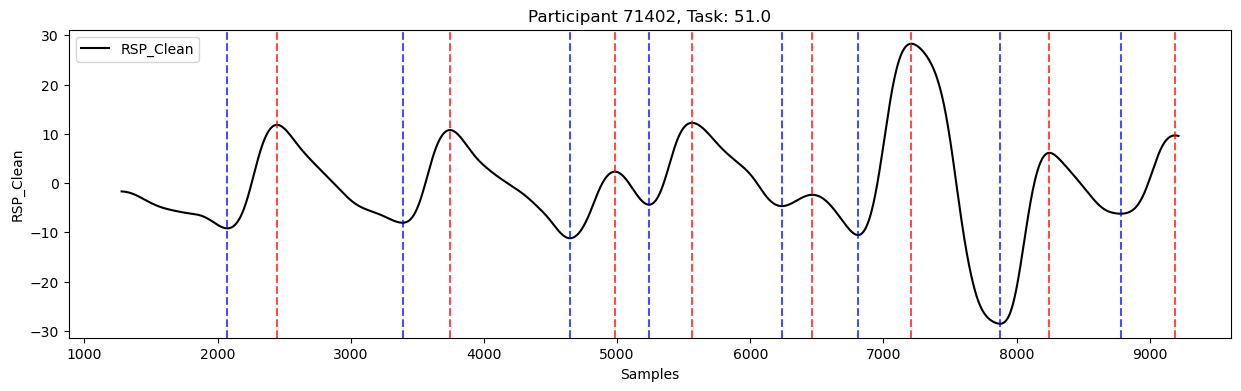

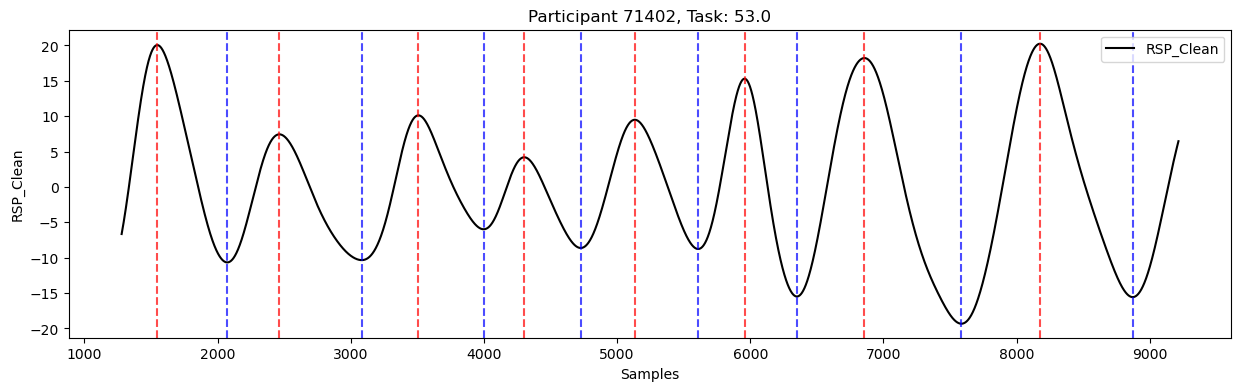

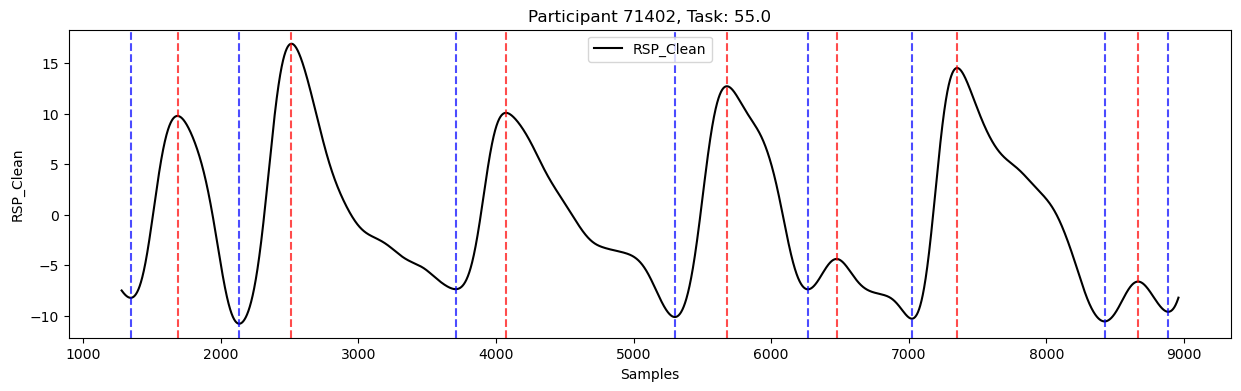

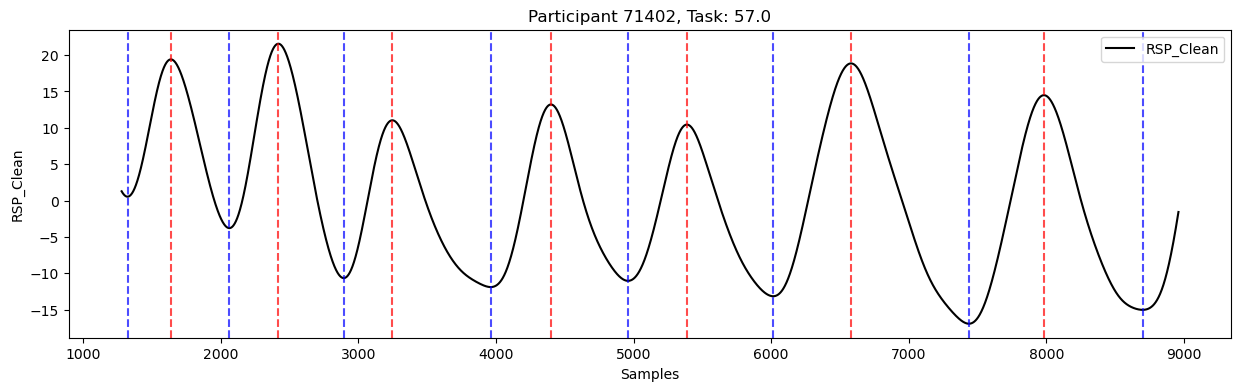

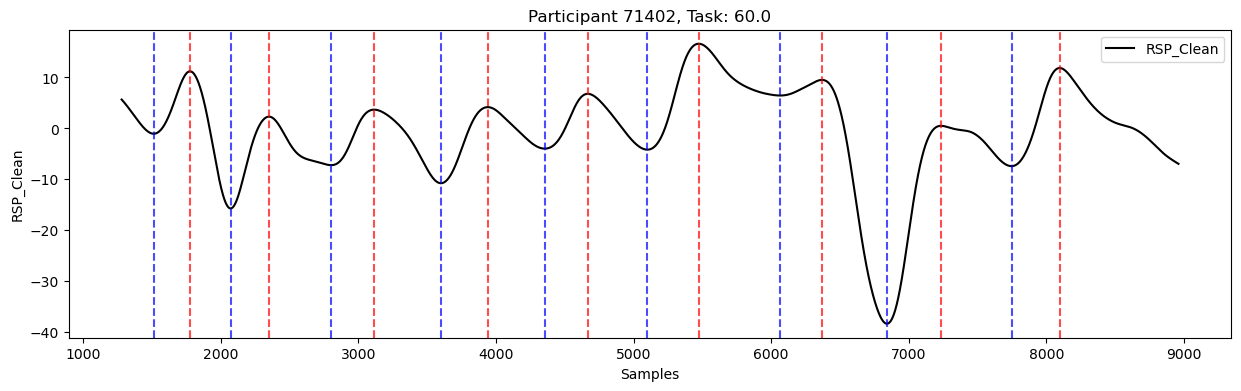

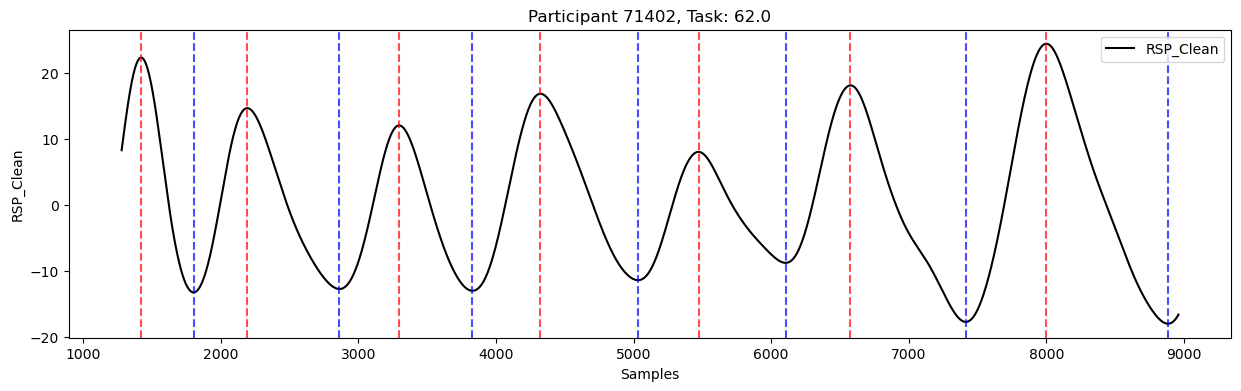

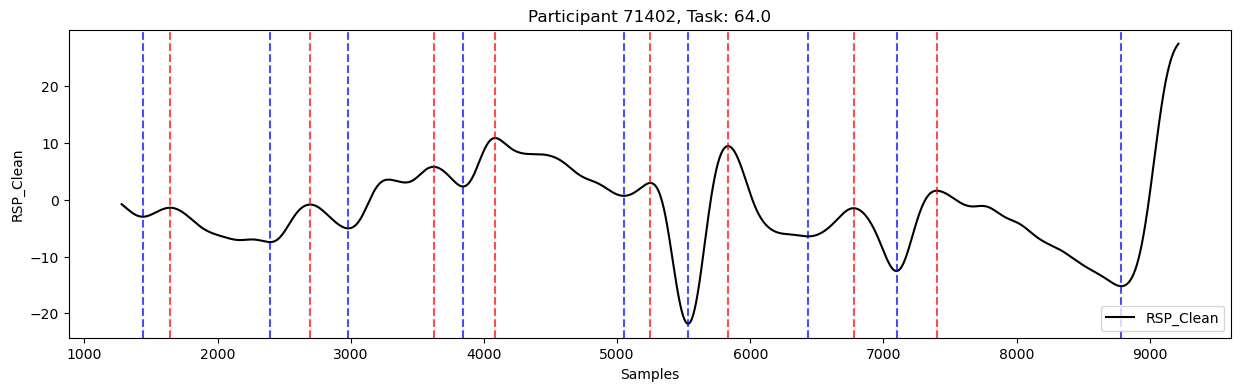

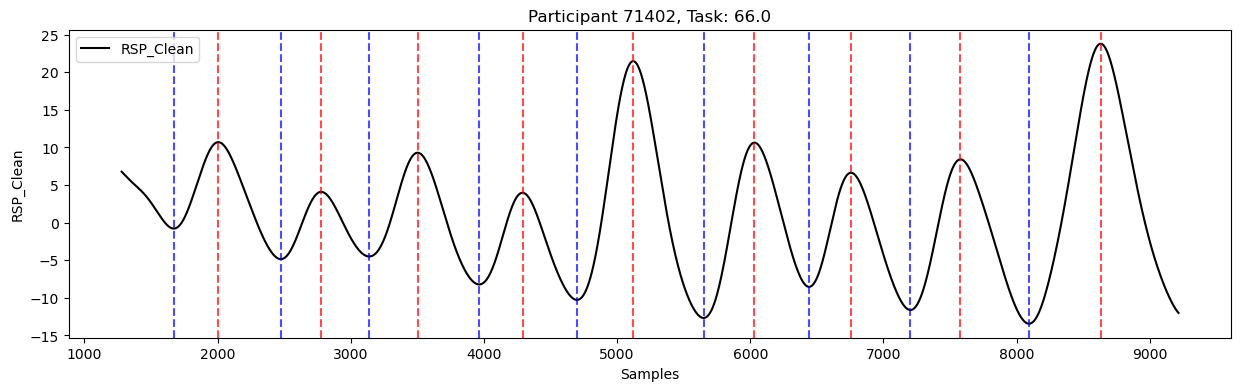

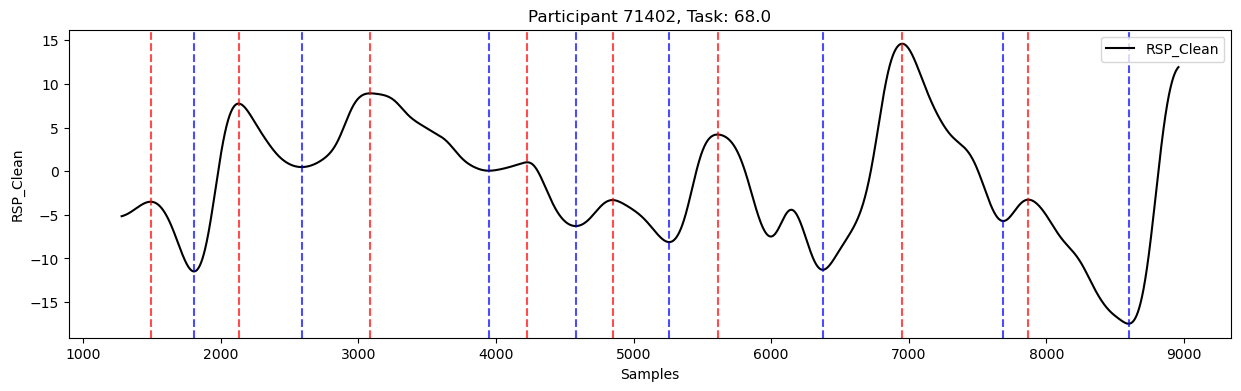

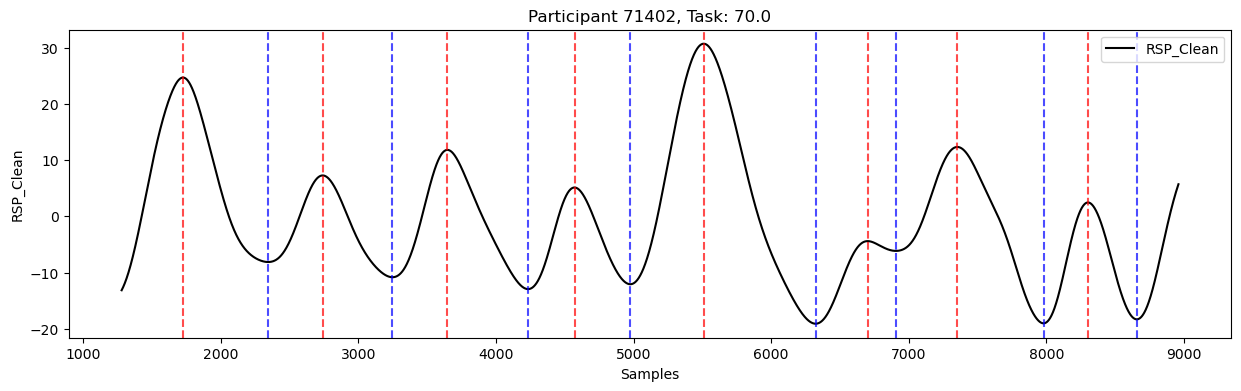

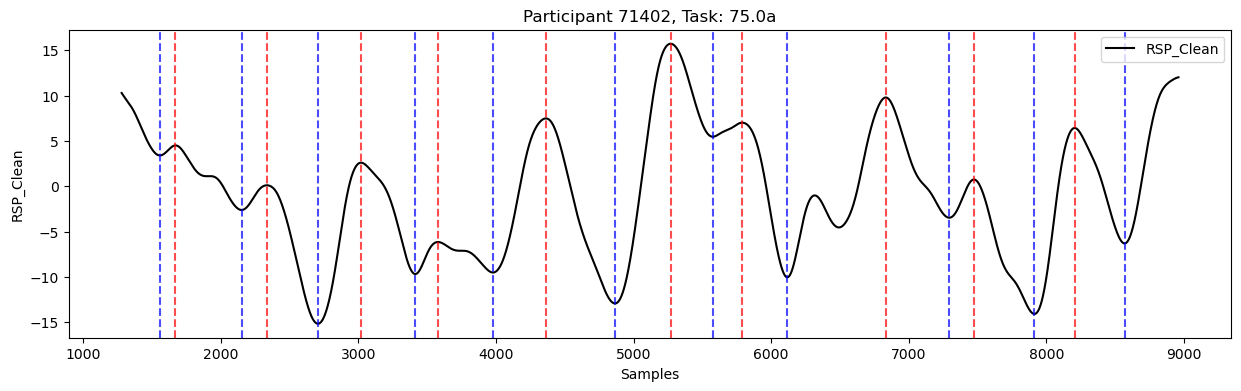

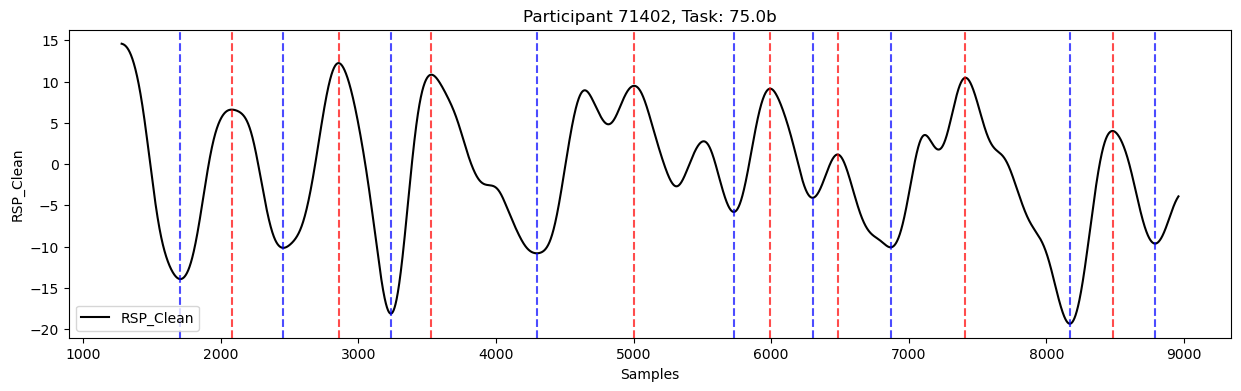

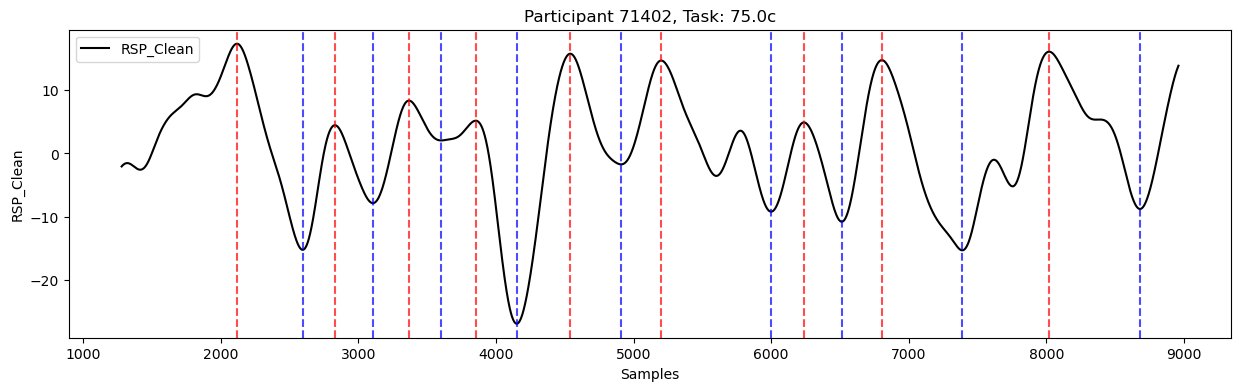

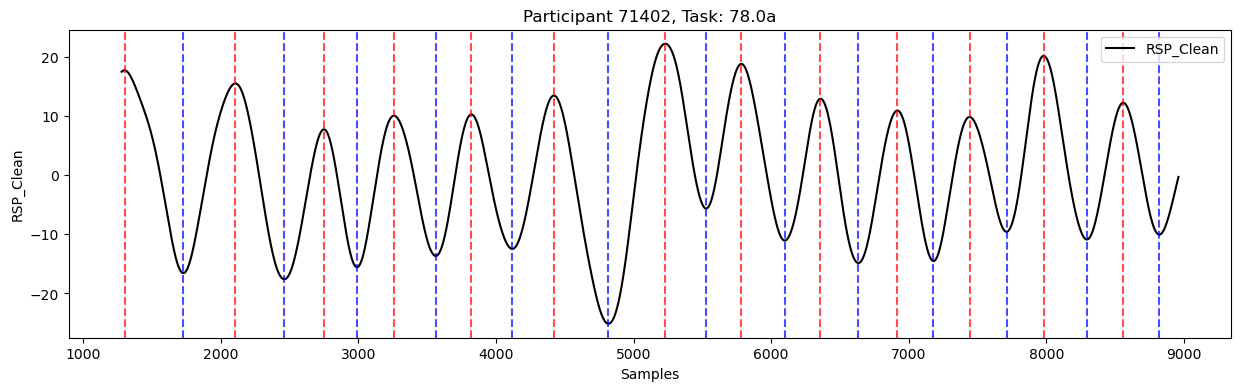

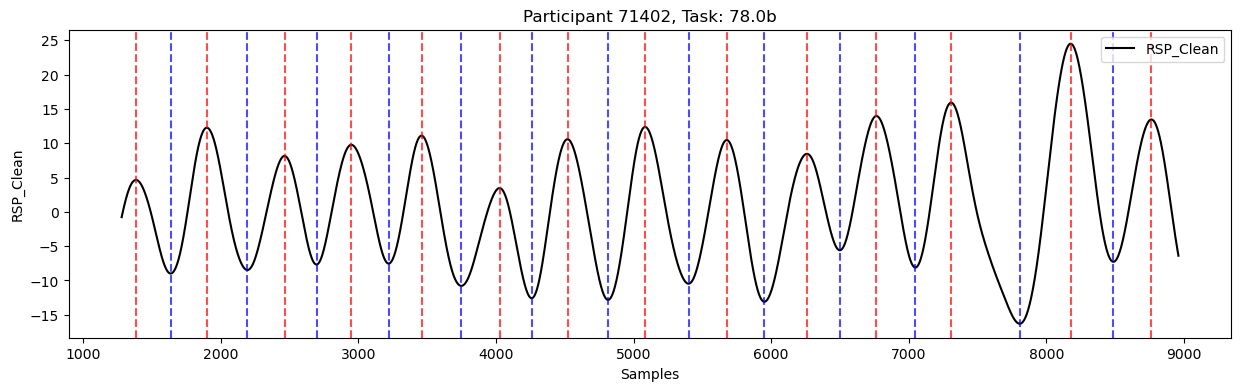

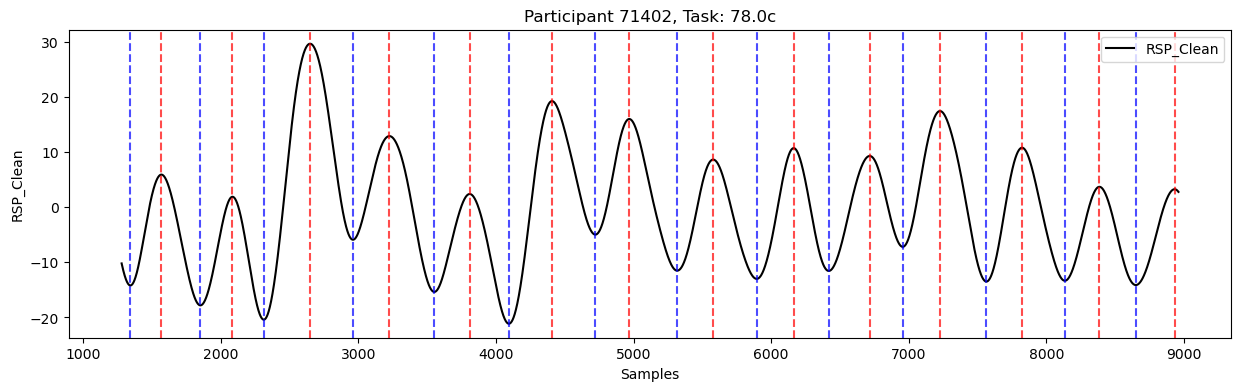

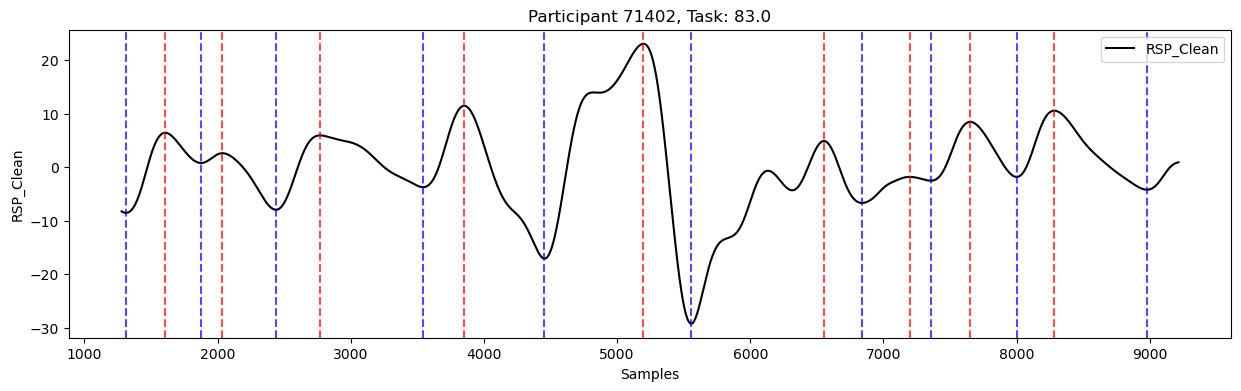

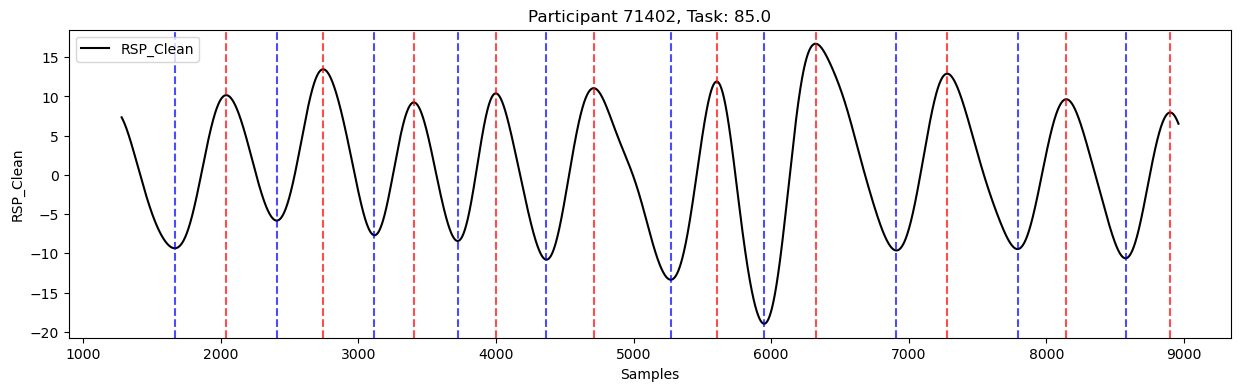

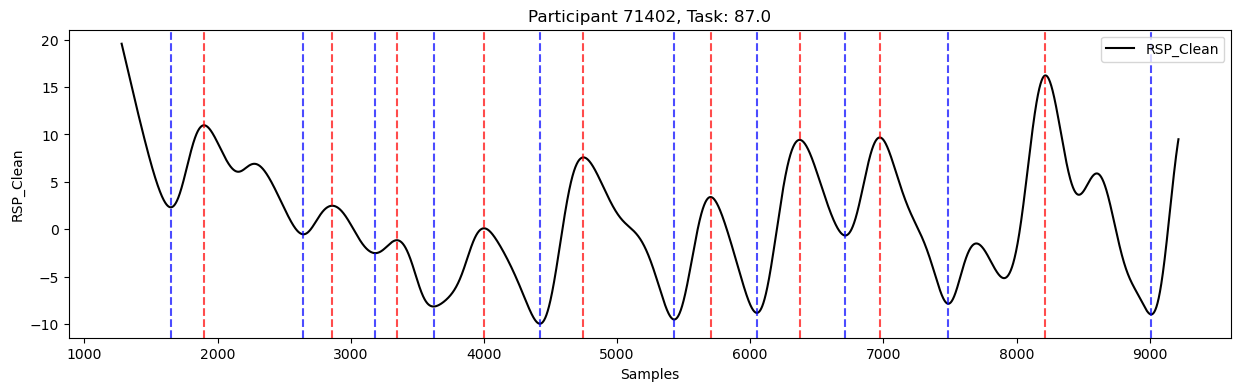

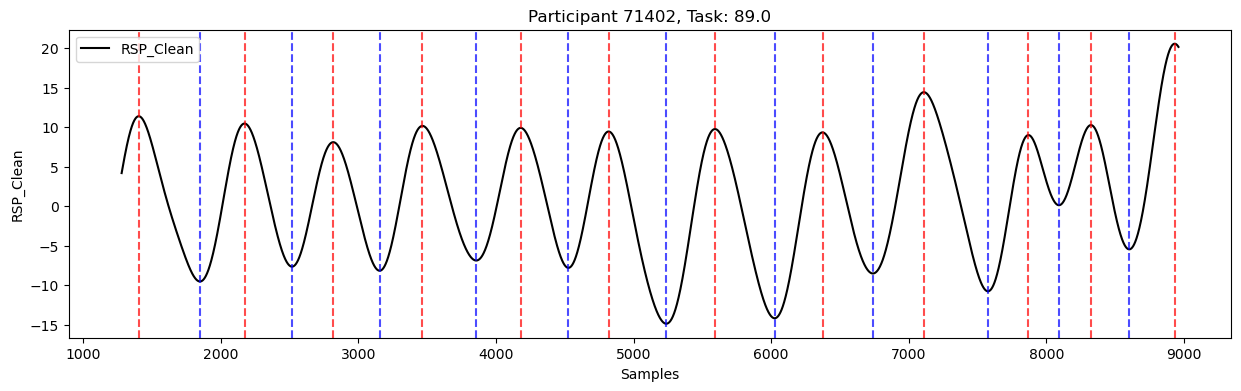

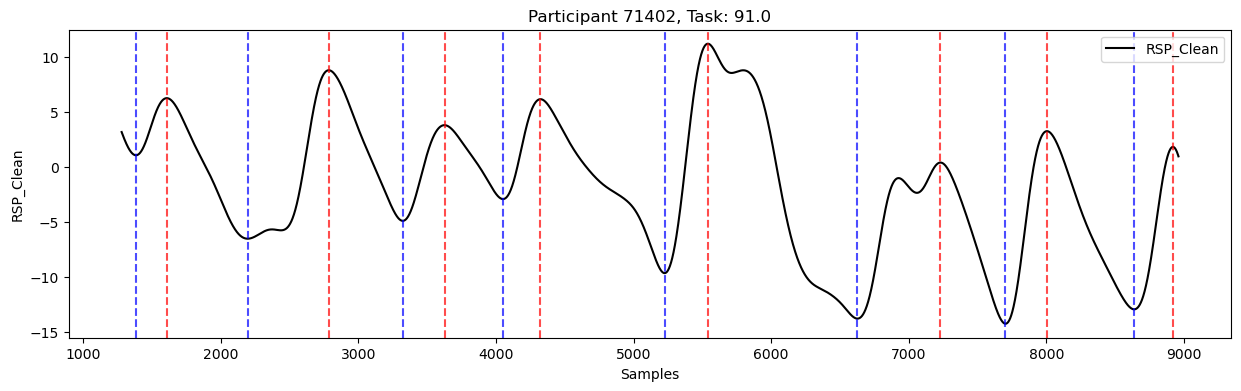

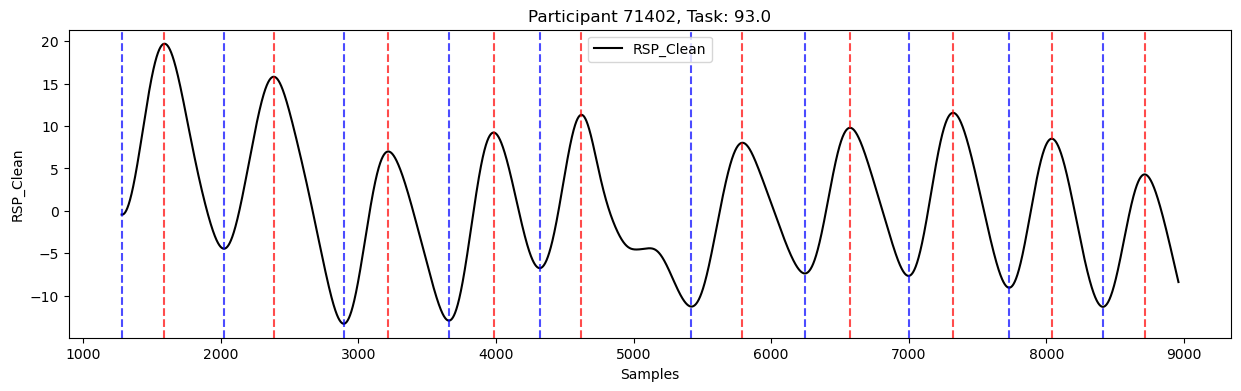

In [4]:
#let's run the function for the dataset we just uploaded
import neurokit2 as nk
import matplotlib.pyplot as plt

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

all_processed_data = {}

all_processed_data = process_and_visualize(df_abdomen, tasks)


In [5]:
all_processed_data #contains, for each segment of interest + 5 seconds before and after, the RSP_Clean, RSP_Peaks, RSP_Troughs
#prior to feature extraction, let's double-check the variable contains the dataframes

{'12.0a':             RSP_Raw  RSP_Clean  RSP_Amplitude   RSP_Rate   RSP_RVT  RSP_Phase  \
 0     -14287.000000  -8.382619      30.132361  13.093035  9.819763        NaN   
 1     -14293.493600  -8.224140      30.132361  13.093035  9.819594        NaN   
 2     -14287.000000  -8.064491      30.132361  13.093035  9.819455        NaN   
 3     -14283.075424  -7.903683      30.132361  13.093035  9.819347        NaN   
 4     -14286.000000  -7.741728      30.132361  13.093035  9.819269        NaN   
 ...             ...        ...            ...        ...       ...        ...   
 10235 -14236.085624  -0.010136      21.094162  19.467681  6.645154        NaN   
 10236 -14234.000000  -0.008468      21.094162  19.467681  6.645147        NaN   
 10237 -14230.119293  -0.007005      21.094162  19.467681  6.645129        NaN   
 10238 -14234.000000  -0.005732      21.094162  19.467681  6.645102        NaN   
 10239 -14248.143220  -0.004634      21.094162  19.467681  6.645064        NaN   
 
     

In [6]:
import numpy as np 
import pandas as pd
#this code extracts features that don't come from neurokit (all features except respiratory rate, RRV, and peak-trough symmtery)
processed_dataframes = all_processed_data
sampling_rate = 256  #if the sampling rate is different for your data, change
task_results = {}
bbb_results = {}

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # filter each dataframe for the actual task duration
    task_specific_df = df[df['Task_Label_2'] == task]
    peaks = task_specific_df[task_specific_df['RSP_Peaks'] == 1].index
    troughs = task_specific_df[task_specific_df['RSP_Troughs'] == 1].index

    # combine peaks and troughs into one list and sort
    combined_data = [('Peak', index) for index in peaks] + [('Trough', index) for index in troughs]
    combined_data.sort(key=lambda x: x[1])

    # initialize lists to store durations, amplitudes, flow rates, I:E ratios, and duty cycles
    inspiratory_durations = []
    expiratory_durations = []
    inspiratory_amplitudes = []
    expiratory_amplitudes = []
    inspiratory_flows = []
    expiratory_flows = []
    ie_ratios = []
    duty_cycles = []
    exp_diffs = []

    # iterate through combined data
    for i in range(1, len(combined_data)):
        current_type, current_index = combined_data[i]
        prev_type, prev_index = combined_data[i-1]

        # calculate duration and amplitude
        duration = (current_index - prev_index) / sampling_rate
        amplitude = abs(df.loc[current_index, 'RSP_Clean'] - df.loc[prev_index, 'RSP_Clean'])

        # calculate inspiratory duration, amplitude, and flow rate
        if current_type == 'Peak' and prev_type == 'Trough':
            inspiratory_durations.append(duration)
            inspiratory_amplitudes.append(amplitude)
            if duration > 0:
                inspiratory_flows.append(amplitude / duration)

        # calculate expiratory duration, amplitude, and flow rate
        elif current_type == 'Trough' and prev_type == 'Peak':
            expiratory_durations.append(duration)
            expiratory_amplitudes.append(amplitude)
            if duration > 0:
                expiratory_flows.append(amplitude / duration)
            if inspiratory_durations:
                ie_ratios.append(inspiratory_durations[-1] / duration)
                # Ensure duty cycle is calculated within each breath cycle
                total_cycle_duration = inspiratory_durations[-1] + expiratory_durations[-1]
                duty_cycle = inspiratory_durations[-1] / total_cycle_duration
                duty_cycles.append(duty_cycle)

    # calculate first-order exhalatory differences
    if len(expiratory_durations) > 1:
        exp_diffs = [abs(expiratory_durations[i] - expiratory_durations[i - 1]) for i in range(1, len(expiratory_durations))]

    # calculate mean and SD for durations, amplitudes, flow rates, I:E ratios, and duty cycles
    insp_dur_mean, insp_dur_sd = np.mean(inspiratory_durations), np.std(inspiratory_durations)
    exp_dur_mean, exp_dur_sd = np.mean(expiratory_durations), np.std(expiratory_durations)
    insp_amp_mean, insp_amp_sd = np.mean(inspiratory_amplitudes), np.std(inspiratory_amplitudes)
    exp_amp_mean, exp_amp_sd = np.mean(expiratory_amplitudes), np.std(expiratory_amplitudes)
    insp_flow_mean, insp_flow_sd = np.mean(inspiratory_flows), np.std(inspiratory_flows)
    exp_flow_mean, exp_flow_sd = np.mean(expiratory_flows), np.std(expiratory_flows)
    ie_ratio_mean, ie_ratio_sd = np.mean(ie_ratios), np.std(ie_ratios)
    duty_cycle_mean = np.mean(duty_cycles)
    exp_diff_mean = np.mean(exp_diffs) if exp_diffs else 0

    task_results[task] = {
        'insp_dur_mean': insp_dur_mean,
        'insp_dur_sd': insp_dur_sd,
        'exp_dur_mean': exp_dur_mean,
        'exp_dur_sd': exp_dur_sd,
        'insp_amp_mean': insp_amp_mean,
        'insp_amp_sd': insp_amp_sd,
        'exp_amp_mean': exp_amp_mean,
        'exp_amp_sd': exp_amp_sd,
        'insp_flow_mean': insp_flow_mean,
        'insp_flow_sd': insp_flow_sd,
        'exp_flow_mean': exp_flow_mean,
        'exp_flow_sd': exp_flow_sd,
        'ie_ratio_mean': ie_ratio_mean,
        'ie_ratio_sd': ie_ratio_sd,
        'duty_cycle_mean': duty_cycle_mean,
        'exp_diff_mean': exp_diff_mean
    }

    # store the breath-by-breath results separately
    bbb_results[task] = {
        'inspiratory_durations': inspiratory_durations,
        'expiratory_durations': expiratory_durations,
        'inspiratory_amplitudes': inspiratory_amplitudes,
        'expiratory_amplitudes': expiratory_amplitudes,
        'inspiratory_flows': inspiratory_flows,
        'expiratory_flows': expiratory_flows,
        'ie_ratios': ie_ratios,
        'duty_cycles': duty_cycles,
        'exp_diffs': exp_diffs
    }

# convert the dictionary to a data frame for task_results
respiratory_analysis_df = pd.DataFrame.from_dict(task_results, orient='index')
respiratory_analysis_df.reset_index(inplace=True)
respiratory_analysis_df.rename(columns={'index': 'Task_Label'}, inplace=True)

# create a dataframe for bbb_results
bbb_dataframe = pd.DataFrame.from_dict(bbb_results, orient='index')
bbb_dataframe.reset_index(inplace=True)
bbb_dataframe.rename(columns={'index': 'Task_Label'}, inplace=True)

#display the dataframe containing the features
respiratory_analysis_df


Task: 12.0a
Task: 12.0b
Task: 12.0c
Task: 12.0d
Task: 12.0e
Task: 12.0f
Task: 14.0a
Task: 14.0b
Task: 14.0c
Task: 14.0d
Task: 14.0e
Task: 14.0f
Task: 16.0a
Task: 16.0b
Task: 16.0c
Task: 16.0d
Task: 16.0e
Task: 16.0f
Task: 18.0a
Task: 18.0b
Task: 18.0c
Task: 20.0a
Task: 20.0b
Task: 20.0c
Task: 23.0a
Task: 23.0b
Task: 23.0c
Task: 25.0a
Task: 25.0b
Task: 25.0c
Task: 28.0a
Task: 28.0b
Task: 28.0c
Task: 30.0a
Task: 30.0b
Task: 30.0c
Task: 34.0
Task: 36.0
Task: 38.0
Task: 40.0
Task: 42.0
Task: 44.0
Task: 47.0
Task: 49.0
Task: 51.0
Task: 53.0
Task: 55.0
Task: 57.0
Task: 60.0
Task: 62.0
Task: 64.0
Task: 66.0
Task: 68.0
Task: 70.0
Task: 75.0a
Task: 75.0b
Task: 75.0c
Task: 78.0a
Task: 78.0b
Task: 78.0c
Task: 83.0
Task: 85.0
Task: 87.0
Task: 89.0
Task: 91.0
Task: 93.0


Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.006510     0.201625      2.498698    0.521240   
1       12.0b       2.019531     0.189878      2.751953    0.403831   
2       12.0c       2.152344     0.362907      3.016927    0.661990   
3       12.0d       2.449219     0.077537      3.424219    0.312857   
4       12.0e       1.954427     0.459394      2.787760    0.814918   
..        ...            ...          ...           ...         ...   
61       85.0       1.316406     0.125548      1.676649    0.366419   
62       87.0       1.266059     0.606641      1.929253    0.731614   
63       89.0       1.234730     0.140046      1.438565    0.274471   
64       91.0       1.411621     0.540073      2.591518    0.875114   
65       93.0       1.271094     0.087105      1.812066    0.496927   

    insp_amp_mean  insp_amp_sd  exp_amp_mean  exp_amp_sd  insp_flow_mean  \
0       35.737058     5.665415     34.263858    6.497320       17.693142   
1       37.153225     3.168234     34.956417    5.519221       18.456435   
2       37.483878     7.897888     38.417164    6.290087       17.335734   
3       40.487563     0.995691     41.039163    1.174700       16.551296   
4       31.761277     9.157753     31.827653    8.085340       16.018326   
..            ...          ...           ...         ...             ...   
61      21.758649     5.169724     22.252999    4.246860       16.490383   
62      11.609257     6.974335     12.865483    5.837719        8.808199   
63      19.546829     4.393989     18.713049    4.492767       15.660074   
64      13.207643     4.829966     14.985667    5.034870        9.967292   
65      18.986467     1.805523     20.569981    4.062173       14.966912   

    insp_flow_sd  exp_flow_mean  exp_flow_sd  ie_ratio_mean  ie_ratio_sd  \
0       1.330750      13.796875     0.571707       0.827804     0.119882   
1       1.389996      12.785845     1.864921       0.721172     0.049212   
2       1.543262      12.964770     1.168839       0.754341     0.071160   
3       0.758774      12.059929     0.873650       0.747375     0.019665   
4       1.723556      11.580177     0.759804       0.764864     0.050343   
..           ...            ...          ...            ...          ...   
61      3.150318      13.706227     3.554868       0.814099     0.135968   
62      4.121487       6.709641     1.750322       0.679999     0.205779   
63      2.342561      12.905757     1.362530       0.896333     0.161207   
64      4.126298       5.860570     1.226263       0.648150     0.368687   
65      1.405324      11.753134     2.386376       0.746137     0.150023   

    duty_cycle_mean  exp_diff_mean  
0          0.450588       0.502344  
1          0.418528       0.477344  
2          0.429048       0.900781  
3          0.427640       0.307617  
4          0.432917       0.928125  
..              ...            ...  
61         0.445619       0.447266  
62         0.395405       0.813477  
63         0.469260       0.296484  
64         0.365079       1.041016  
65         0.422463       0.557129  

[66 rows x 17 columns]

In [7]:
#we also need to add the features from neurokit2's function, below we run the intervalrelated function of neurokit2

import pandas as pd
import neurokit2 as nk

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

processed_dataframes = all_processed_data

# initializing empty list
interval_features_list = []

# iterate over task dataframes
for task, df in processed_dataframes.items():
    try:
        # filtering the dataframe for the actual task duration
        task_specific_df = df[df['Task_Label_2'] == task]

        # extracting interval-related features 
        features_df = nk.rsp_intervalrelated(task_specific_df, sampling_rate=256)

        # adding a column for the task label
        features_df['Task_Label'] = task

        # appending the features DataFrame to the list
        interval_features_list.append(features_df)
    except Exception as e:
        print(f"Error processing task {task}: {e}")

# concatenate all feature dataframes
interval_features_df = pd.concat(interval_features_list, ignore_index=True)
interval_features_df

C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)
C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)


RSP_Rate_Mean    RRV_RMSSD   RRV_MeanBB     RRV_SDBB     RRV_SDSD  \
0       12.702575   651.955348  4505.208333   772.105334   578.959754   
1       13.199147  1075.482212  4840.625000   653.934718  1241.857841   
2       11.658219  1869.609969  5062.500000  1147.028260  2143.878627   
3       10.298636   178.009603  5728.515625   227.290945    43.204844   
4       12.755209  1882.765900  4566.406250  1416.464099  1957.922493   
..            ...          ...          ...          ...          ...   
61      19.785279   655.732450  2998.697917   482.421875   700.631118   
62      18.624737  1460.272163  3195.312500  1274.835673  1536.667651   
63      22.713080   481.642367  2637.500000   403.976679   505.587825   
64      15.214693  1270.159100  4047.433036   898.424560  1388.621604   
65      19.362621   780.288715  3092.881944   519.963466   833.594999   

    RRV_CVBB  RRV_CVSD  RRV_MedianBB    RRV_MadBB  RRV_MCVBB  ...    RAV_SD  \
0   0.171381  0.144711   4746.093750   550.183594   0.115923  ...  6.206151   
1   0.135093  0.222178   4570.312500   127.410937   0.027878  ...  6.847969   
2   0.226573  0.369306   5175.781250  1054.035938   0.203648  ...  8.264574   
3   0.039677  0.031074   5707.031250   228.760547   0.040084  ...  1.038837   
4   0.310192  0.412308   5222.656250  1401.520312   0.268354  ...  9.812941   
..       ...       ...           ...          ...        ...  ...       ...   
61  0.160877  0.218672   2894.531250   555.975000   0.192078  ...  5.449368   
62  0.398971  0.457004   3023.437500  1285.692187   0.425242  ...  7.397399   
63  0.153167  0.182613   2677.734375   222.969141   0.083268  ...  4.403001   
64  0.221974  0.313818   4203.125000   816.588281   0.194281  ...  5.163451   
65  0.168116  0.252285   2941.406250   416.981250   0.141763  ...  1.903188   

    RAV_RMSSD  RAV_CVSD   RSP_RVT  RSP_Symmetry_PeakTrough  \
0    6.825416  0.190990  7.289946                 0.541614   
1    9.254376  0.266891  7.317709                 0.523744   
2   10.743843  0.279222  7.150614                 0.547989   
3    1.313536  0.032337  6.682674                 0.554263   
4   14.399648  0.435116  6.626110                 0.557130   
..        ...       ...       ...                      ...   
61   5.999635  0.275736  7.315369                 0.505654   
62   7.668664  0.660565  3.091058                 0.496446   
63   6.322742  0.324817  6.592729                 0.507242   
64   7.055211  0.534176  2.776355                 0.488752   
65   2.032104  0.107029  6.217114                 0.521531   

    RSP_Symmetry_RiseDecay  RSP_Phase_Duration_Inspiration  \
0                 0.439581                        2.002604   
1                 0.413030                        2.015625   
2                 0.421839                        2.148438   
3                 0.419202                        2.445312   
4                 0.428999                        1.950521   
..                     ...                             ...   
61                0.448219                        1.312500   
62                0.402109                        1.262153   
63                0.464543                        1.230824   
64                0.371595                        1.407715   
65                0.422943                        1.267187   

    RSP_Phase_Duration_Expiration  RSP_Phase_Duration_Ratio  Task_Label  
0                        2.494792                  0.802714       12.0a  
1                        2.748047                  0.733475       12.0b  
2                        3.013021                  0.713051       12.0c  
3                        3.420313                  0.714938       12.0d  
4                        2.783854                  0.700655       12.0e  
..                            ...                       ...         ...  
61                       1.672743                  0.784639        85.0  
62                       1.925347                  0.655546        87.0  
63                    

In [8]:
import pandas as pd

#let's add the three features we need from neurokit into the previous dataframe of features

selected_columns = interval_features_df[['Task_Label', 'RSP_Symmetry_PeakTrough', 'RRV_RMSSD', 'RSP_Rate_Mean']]

respiratory_analysis_df_2 = pd.merge(respiratory_analysis_df, selected_columns, on='Task_Label', how='left')

In [9]:
# checking if there are any missing values
missing_values = respiratory_analysis_df_2.isnull().sum()

print("Missing values in respiratory_analysis_df_2:")
print(missing_values)

for column in respiratory_analysis_df_2.columns:
    if column != 'Task_Label' and missing_values[column] > 0:
        missing_task_label_values = respiratory_analysis_df_2[respiratory_analysis_df_2[column].isnull()]['Task_Label']
        print(f"Missing values in '{column}' column. Corresponding values in 'Task_Label' column:")
        print(missing_task_label_values)



Missing values in respiratory_analysis_df_2:
Task_Label                 0
insp_dur_mean              0
insp_dur_sd                0
exp_dur_mean               0
exp_dur_sd                 0
insp_amp_mean              0
insp_amp_sd                0
exp_amp_mean               0
exp_amp_sd                 0
insp_flow_mean             0
insp_flow_sd               0
exp_flow_mean              0
exp_flow_sd                0
ie_ratio_mean              0
ie_ratio_sd                0
duty_cycle_mean            0
exp_diff_mean              0
RSP_Symmetry_PeakTrough    0
RRV_RMSSD                  0
RSP_Rate_Mean              0
dtype: int64


In [ ]:
#Run this cell if there is a missing value: THIS IMPUTES FOR THE MISSING VALUES OF RR, RMSSD, PEAK TROUGH with the average of
#the individual's all other values for the feature
#If there are no missing values, you may skip this cell

import pandas as pd
from sklearn.impute import SimpleImputer

task_label_column = respiratory_analysis_df_2['Task_Label']

data_for_imputation = respiratory_analysis_df_2.drop(columns=['Task_Label'])

# creating an instance of SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# applying the imputer to the data frame (excluding 'Task_Label' column)
imputed_data = pd.DataFrame(imputer.fit_transform(data_for_imputation), columns=data_for_imputation.columns)

# concatenating the imputed data with the 'Task_Label' column
respiratory_analysis_df_2 = pd.concat([task_label_column, imputed_data], axis=1)

print("DataFrame with imputed values:")
print(respiratory_analysis_df_2)

In [10]:
# We add the inspiratory minute depth (or volume) by multiplying the mean inspiratory depth with the mean respiratory rate
respiratory_analysis_df_2['insp_minu_depth'] = respiratory_analysis_df_2['insp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

#Repeat of expiratory minute depth
respiratory_analysis_df_2['exp_minu_depth'] = respiratory_analysis_df_2['exp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

respiratory_analysis_df_2

#if wanted, we can add a new column with the participant number
#respiratory_analysis_df_2['Participant'] = 58682

Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.006510     0.201625      2.498698    0.521240   
1       12.0b       2.019531     0.189878      2.751953    0.403831   
2       12.0c       2.152344     0.362907      3.016927    0.661990   
3       12.0d       2.449219     0.077537      3.424219    0.312857   
4       12.0e       1.954427     0.459394      2.787760    0.814918   
..        ...            ...          ...           ...         ...   
61       85.0       1.316406     0.125548      1.676649    0.366419   
62       87.0       1.266059     0.606641      1.929253    0.731614   
63       89.0       1.234730     0.140046      1.438565    0.274471   
64       91.0       1.411621     0.540073      2.591518    0.875114   
65       93.0       1.271094     0.087105      1.812066    0.496927   

    insp_amp_mean  insp_amp_sd  exp_amp_mean  exp_amp_sd  insp_flow_mean  ...  \
0       35.737058     5.665415     34.263858    6.497320       17.693142  ...   
1       37.153225     3.168234     34.956417    5.519221       18.456435  ...   
2       37.483878     7.897888     38.417164    6.290087       17.335734  ...   
3       40.487563     0.995691     41.039163    1.174700       16.551296  ...   
4       31.761277     9.157753     31.827653    8.085340       16.018326  ...   
..            ...          ...           ...         ...             ...  ...   
61      21.758649     5.169724     22.252999    4.246860       16.490383  ...   
62      11.609257     6.974335     12.865483    5.837719        8.808199  ...   
63      19.546829     4.393989     18.713049    4.492767       15.660074  ...   
64      13.207643     4.829966     14.985667    5.034870        9.967292  ...   
65      18.986467     1.805523     20.569981    4.062173       14.966912  ...   

    exp_flow_sd  ie_ratio_mean  ie_ratio_sd  duty_cycle_mean  exp_diff_mean  \
0      0.571707       0.827804     0.119882         0.450588       0.502344   
1      1.864921       0.721172     0.049212         0.418528       0.477344   
2      1.168839       0.754341     0.071160         0.429048       0.900781   
3      0.873650       0.747375     0.019665         0.427640       0.307617   
4      0.759804       0.764864     0.050343         0.432917       0.928125   
..          ...            ...          ...              ...            ...   
61     3.554868       0.814099     0.135968         0.445619       0.447266   
62     1.750322       0.679999     0.205779         0.395405       0.813477   
63     1.362530       0.896333     0.161207         0.469260       0.296484   
64     1.226263       0.648150     0.368687         0.365079       1.041016   
65     2.386376       0.746137     0.150023         0.422463       0.557129   

    RSP_Symmetry_PeakTrough    RRV_RMSSD  RSP_Rate_Mean  insp_minu_depth  \
0                  0.541614   651.955348      12.702575       453.952661   
1                  0.523744  1075.482212      13.199147       490.390884   
2                  0.547989  1869.609969      11.658219       436.995261   
3                  0.554263   178.009603      10.298636       416.966687   
4                  0.557130  1882.765900      12.755209       405.121724   
..                      ...          ...            ...              ...   
61                 0.505654   655.732450      19.785279       430.500946   
62                 0.496446  1460.272163      18.624737       216.219362   
63                 0.507242   481.642367      22.713080       443.968681   
64                 0.488752  1270.159100      15.214693       200.950240   
65                 0.521531   780.288715      19.362621       367.627768   

    exp_minu_depth  
0       435.239230  
1       461.394891  
2       447.875708  
3       422.647421  
4       405.968360  
..             ...  
61      440.281784  
62      239.616248  
63      425.030978  
64      228.002326  
65      398.288755  

[66 rows x 22 columns]

In [11]:
# adding A_ to the beginning of all column names
respiratory_analysis_df_2.columns = 'A_' + respiratory_analysis_df_2.columns
respiratory_analysis_df_2

A_Task_Label  A_insp_dur_mean  A_insp_dur_sd  A_exp_dur_mean  A_exp_dur_sd  \
0         12.0a         2.006510       0.201625        2.498698      0.521240   
1         12.0b         2.019531       0.189878        2.751953      0.403831   
2         12.0c         2.152344       0.362907        3.016927      0.661990   
3         12.0d         2.449219       0.077537        3.424219      0.312857   
4         12.0e         1.954427       0.459394        2.787760      0.814918   
..          ...              ...            ...             ...           ...   
61         85.0         1.316406       0.125548        1.676649      0.366419   
62         87.0         1.266059       0.606641        1.929253      0.731614   
63         89.0         1.234730       0.140046        1.438565      0.274471   
64         91.0         1.411621       0.540073        2.591518      0.875114   
65         93.0         1.271094       0.087105        1.812066      0.496927   

    A_insp_amp_mean  A_insp_amp_sd  A_exp_amp_mean  A_exp_amp_sd  \
0         35.737058       5.665415       34.263858      6.497320   
1         37.153225       3.168234       34.956417      5.519221   
2         37.483878       7.897888       38.417164      6.290087   
3         40.487563       0.995691       41.039163      1.174700   
4         31.761277       9.157753       31.827653      8.085340   
..              ...            ...             ...           ...   
61        21.758649       5.169724       22.252999      4.246860   
62        11.609257       6.974335       12.865483      5.837719   
63        19.546829       4.393989       18.713049      4.492767   
64        13.207643       4.829966       14.985667      5.034870   
65        18.986467       1.805523       20.569981      4.062173   

    A_insp_flow_mean  ...  A_exp_flow_sd  A_ie_ratio_mean  A_ie_ratio_sd  \
0          17.693142  ...       0.571707         0.827804       0.119882   
1          18.456435  ...       1.864921         0.721172       0.049212   
2          17.335734  ...       1.168839         0.754341       0.071160   
3          16.551296  ...       0.873650         0.747375       0.019665   
4          16.018326  ...       0.759804         0.764864       0.050343   
..               ...  ...            ...              ...            ...   
61         16.490383  ...       3.554868         0.814099       0.135968   
62          8.808199  ...       1.750322         0.679999       0.205779   
63         15.660074  ...       1.362530         0.896333       0.161207   
64          9.967292  ...       1.226263         0.648150       0.368687   
65         14.966912  ...       2.386376         0.746137       0.150023   

    A_duty_cycle_mean  A_exp_diff_mean  A_RSP_Symmetry_PeakTrough  \
0            0.450588         0.502344                   0.541614   
1            0.418528         0.477344                   0.523744   
2            0.429048         0.900781                   0.547989   
3            0.427640         0.307617                   0.554263   
4            0.432917         0.928125                   0.557130   
..                ...              ...                        ...   
61           0.445619         0.447266                   0.505654   
62           0.395405         0.813477                   0.496446   
63           0.469260         0.296484                   0.507242   
64           0.365079         1.041016                   0.488752   
65           0.422463         0.557129                   0.521531   

    A_RRV_RMSSD  A_RSP_Rate_Mean  A_insp_minu_depth  A_exp_minu_depth  
0    651.955348        12.702575         453.952661        435.239230  
1   1075.482212        13.199147         490.390884        461.394891  
2   1869.609969        11.658219         436.995261        447.875708  
3    178.009603        10.298636         416.966687        422.647421  
4   1882.765900        12.755209         405.121724        405.968360  
..          ...              ...       

In [12]:
#extract the dataframe as Excel file

import pandas as pd

writer = pd.ExcelWriter('features_hexoskin_71402_abdomen.xlsx', engine='xlsxwriter')

respiratory_analysis_df_2.to_excel(writer, index=False, float_format='%.7f', sheet_name='Sheet1')

writer.save()

C:\Users\msa583\AppData\Local\Temp\ipykernel_13684\929118645.py:9: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
